In [ ]:
# resnet is based on - paper - deep residual learning for image recognition

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import copy

In [2]:
# to find out whether there is actuall GPU or not in this particular instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Dataset, transform and visualization
# declare transform_train, transform_test objects
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

transform_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [4]:
# create the train dataset and transform
# CIFAR10 dataset has 32 X 32 images
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform = transform_train)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# create the test dataset and transform
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

Files already downloaded and verified


In [7]:
# https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models

In [8]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# set the requires_grad attribute of each parameter as false
# if i am doing back propogation, dont go and update certain weight or bias
for param in resnet.parameters():
  param.requires_grad = False

In [11]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features,num_classes)

In [13]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [14]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(),lr=0.05)

In [18]:
num_classes = 10
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [17]:
def evaluation(dataloader,model):
  total, correct = 0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    return 100*correct/total

min loss 1.82 
Iteration: 0/3125, Loss: 1.82
min loss 0.69 
Iteration: 100/3125, Loss: 2.66
Iteration: 200/3125, Loss: 3.95
min loss 0.64 
Iteration: 300/3125, Loss: 3.07
Iteration: 400/3125, Loss: 1.25
Iteration: 500/3125, Loss: 1.12
Iteration: 600/3125, Loss: 2.29
min loss 0.47 
Iteration: 700/3125, Loss: 1.35
Iteration: 800/3125, Loss: 2.65
Iteration: 900/3125, Loss: 1.09
Iteration: 1000/3125, Loss: 1.22
Iteration: 1100/3125, Loss: 1.82
Iteration: 1200/3125, Loss: 3.15
min loss 0.35 
Iteration: 1300/3125, Loss: 1.00
Iteration: 1400/3125, Loss: 1.08
Iteration: 1500/3125, Loss: 2.30
Iteration: 1600/3125, Loss: 2.84
Iteration: 1700/3125, Loss: 1.94
Iteration: 1800/3125, Loss: 1.35
Iteration: 1900/3125, Loss: 2.25
Iteration: 2000/3125, Loss: 1.27
Iteration: 2100/3125, Loss: 1.82
Iteration: 2200/3125, Loss: 2.37
Iteration: 2300/3125, Loss: 1.50
Iteration: 2400/3125, Loss: 2.28
Iteration: 2500/3125, Loss: 1.65
Iteration: 2600/3125, Loss: 1.97
Iteration: 2700/3125, Loss: 2.55
Iteration: 28

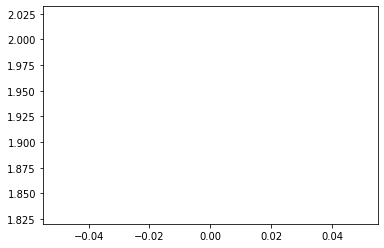

In [21]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader,0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('min loss %0.2f ' % min_loss)

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  plt.plot(loss_epoch_arr)
  plt.show()

In [22]:
# the network will import the weights of all parameters as per the best_model
resnet.load_state_dict(best_model)
print(evaluation(testloader,resnet), evaluation(trainloader,resnet))

43.75 62.5
